<a href="https://colab.research.google.com/github/pandurangpatil/erav4-backpropbay/blob/main/session8-more-trials/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training CIFAR-100 Model (Google Colab)

This notebook trains a model on CIFAR-100 using Google Colab's GPU with the **new modular codebase**.

**Training Configuration:**
- Model: wideresnet28-10 (WideResNet-28-10) or resnet50 (ResNet50)
- Epochs: 50
- Batch Size: 256
- Scheduler: OneCycle Learning Rate Policy
- LR Finder: Enabled (automatically finds optimal learning rate)

**Modular Structure:**
- Datasets in `datasets/` - Easy to add new datasets
- Models in `models/` - Clean separation of architectures  
- Training components in `training/` - Reusable optimizer, scheduler, LR finder
- Utilities in `utils/` - Checkpointing, metrics, HuggingFace upload

## Clone Repository

In [5]:
# Clone the repository
!git clone https://github.com/pandurangpatil/erav4-backpropbay.git

Cloning into 'erav4-backpropbay'...
remote: Enumerating objects: 292, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 292 (delta 12), reused 40 (delta 10), pack-reused 242 (from 1)
Receiving objects: 100% (292/292), 3.71 MiB | 19.40 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [6]:
# Navigate to the session8-more-trials directory
%cd erav4-backpropbay/session8-more-trials

/content/erav4-backpropbay/session8-more-trials/erav4-backpropbay/session8-more-trials


## Install Dependencies

In [7]:
# Install dependencies from requirements.txt
!pip install -r requirements.txt -q

## Check GPU Availability

In [8]:
import torch
import sys

print("="*70)
print("ENVIRONMENT INFORMATION")
print("="*70)
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")

if torch.cuda.is_available():
    print(f"\n✓ CUDA is available")
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  CUDA Version: {torch.version.cuda}")
    print(f"  Number of GPUs: {torch.cuda.device_count()}")

    # Show GPU memory
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"  GPU Memory: {gpu_memory:.2f} GB")
    device = torch.device('cuda')
else:
    print(f"\n⚠ WARNING: CUDA is not available!")
    print(f"  Training will be very slow on CPU.")
    print(f"  Please enable GPU in Colab: Runtime > Change runtime type > GPU")
    device = torch.device('cpu')

print(f"\n✓ Using device: {device}")
print("="*70)

ENVIRONMENT INFORMATION
Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch Version: 2.8.0+cu126

✓ CUDA is available
  GPU: Tesla T4
  CUDA Version: 12.6
  Number of GPUs: 1
  GPU Memory: 14.74 GB

✓ Using device: cuda


## Setup HuggingFace Token (Optional)

If you want to upload your trained model to HuggingFace Hub:
1. Go to Colab Secrets (🔑 icon in left sidebar)
2. Add a secret named `HF_TOKEN` with your HuggingFace API token
3. Update `HF_REPO_ID` below with your repository name

In [9]:
# Setup HuggingFace token from Colab secrets (optional)
HF_TOKEN = None
HF_REPO_ID = None

try:
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
    HF_REPO_ID = 'your-username/cifar100-session8'  # ⚠️ Change this to your repo!
    print("✓ HuggingFace token retrieved from Colab secrets")
    print(f"✓ Will upload to: {HF_REPO_ID}")
    print("\n⚠️ Remember to update HF_REPO_ID with your actual repository name!")
except Exception as e:
    print(f"ℹ️ HuggingFace token not found in secrets")
    print("  Training will proceed without HuggingFace upload")
    print("  Models will be saved locally in checkpoint folders")

ℹ️ HuggingFace token not found in secrets
  Training will proceed without HuggingFace upload
  Models will be saved locally in checkpoint folders


## Verify Training Files

In [10]:
import os

print("\n" + "="*70)
print("VERIFYING TRAINING FILES AND MODULAR STRUCTURE")
print("="*70)

# Check required files
required_files = ['train.py', 'config.json', 'requirements.txt']
print("\nRequired Files:")
files_ok = True
for file in required_files:
    exists = os.path.exists(file)
    status = "✓" if exists else "✗"
    print(f"{status} {file}")
    if not exists:
        files_ok = False

# Check modular directories
required_dirs = ['datasets', 'models', 'training', 'utils']
print("\nModular Directories:")
dirs_ok = True
for dir in required_dirs:
    exists = os.path.isdir(dir)
    status = "✓" if exists else "✗"
    print(f"{status} {dir}/")
    if not exists:
        dirs_ok = False

print("="*70)
if files_ok and dirs_ok:
    print("✓ All required files and modular structure verified!")
else:
    print("⚠ Some files or directories are missing!")
print("="*70)


VERIFYING TRAINING FILES AND MODULAR STRUCTURE

Required Files:
✓ train.py
✓ config.json
✓ requirements.txt

Modular Directories:
✗ datasets/
✓ models/
✓ training/
✓ utils/
⚠ Some files or directories are missing!


## Training Configuration

The training will use the following settings with the **new modular codebase**:

### Command Line Arguments:
- `--epochs 50` - Train for 50 epochs
- `--batch-size 256` - Use batch size of 256
- `--model wideresnet28-10` - Use WideResNet-28-10 architecture from `models/wideresnet.py`
  - Alternative: `--model resnet50` for ResNet50 from `models/resnet50.py`
- `--scheduler onecycle` - Use OneCycle learning rate scheduler
- `--lr-finder` - Automatically find optimal learning rate before training

### What happens during training:

**Phase 1: LR Finder (3 epochs)**
- Runs a learning rate range test from 1e-6 to 1.0
- Identifies optimal `max_lr` and `base_lr` for OneCycle scheduler
- Saves plot to `checkpoint_N/lr_finder_plot.png`
- Restores model to initial state

**Phase 2: Main Training (50 epochs)**
- Uses OneCycle scheduler with automatically found learning rates
- Applies MixUp augmentation (alpha=0.2)
- Uses label smoothing (0.1)
- Gradient clipping (max_norm=1.0)
- Mixed precision training (AMP)
- Early stopping (patience=15)

### Checkpoints:
- Best model saved automatically when test accuracy improves
- Checkpoint folders named `checkpoint_1`, `checkpoint_2`, etc.
- Each folder contains: best_model.pth, metrics.json, training_curves.png, config.json, README.md

### Available Models:
- `wideresnet28-10` - WideResNet-28-10 (36.5M parameters, default)
- `resnet50` - ResNet50 (23.5M parameters)

## Start Training

**⏱️ Expected Time:** ~2-3 hours on Colab's T4 GPU

**Note:** The cell below will run for a long time. You can monitor progress through the output below.

In [11]:
# Build the training command with modular codebase
# Using WideResNet-28-10 (change to 'resnet50' if desired)
MODEL = "resnet50"  # or "resnet50"

cmd = f"python train.py --epochs 50 --batch-size 256 --model {MODEL} --scheduler onecycle --lr-finder"

# Add HuggingFace parameters if available
if HF_TOKEN and HF_REPO_ID:
    cmd += f" --hf-token {HF_TOKEN} --hf-repo {HF_REPO_ID}"
    print(f"✓ HuggingFace upload enabled: {HF_REPO_ID}")
else:
    print("ℹ️ Training without HuggingFace upload")

print(f"\nRunning command: {cmd.replace(HF_TOKEN or '', '***TOKEN***')}\n")
print("="*70)

# Run training
!{cmd}

ℹ️ Training without HuggingFace upload

Running command: ***TOKEN***p***TOKEN***y***TOKEN***t***TOKEN***h***TOKEN***o***TOKEN***n***TOKEN*** ***TOKEN***t***TOKEN***r***TOKEN***a***TOKEN***i***TOKEN***n***TOKEN***.***TOKEN***p***TOKEN***y***TOKEN*** ***TOKEN***-***TOKEN***-***TOKEN***e***TOKEN***p***TOKEN***o***TOKEN***c***TOKEN***h***TOKEN***s***TOKEN*** ***TOKEN***5***TOKEN***0***TOKEN*** ***TOKEN***-***TOKEN***-***TOKEN***b***TOKEN***a***TOKEN***t***TOKEN***c***TOKEN***h***TOKEN***-***TOKEN***s***TOKEN***i***TOKEN***z***TOKEN***e***TOKEN*** ***TOKEN***2***TOKEN***5***TOKEN***6***TOKEN*** ***TOKEN***-***TOKEN***-***TOKEN***m***TOKEN***o***TOKEN***d***TOKEN***e***TOKEN***l***TOKEN*** ***TOKEN***r***TOKEN***e***TOKEN***s***TOKEN***n***TOKEN***e***TOKEN***t***TOKEN***5***TOKEN***0***TOKEN*** ***TOKEN***-***TOKEN***-***TOKEN***s***TOKEN***c***TOKEN***h***TOKEN***e***TOKEN***d***TOKEN***u***TOKEN***l***TOKEN***e***TOKEN***r***TOKEN*** ***TOKEN***o***TOKEN***n***TOKEN***e***TOKEN***c***TOKE

## Training Complete - View Results

In [12]:
import glob
import json
import os

# Find the latest checkpoint directory
checkpoint_dirs = sorted(glob.glob('checkpoint_*'), reverse=True)

if checkpoint_dirs:
    latest_checkpoint = checkpoint_dirs[0]
    print(f"\n{'='*70}")
    print(f"LATEST CHECKPOINT: {latest_checkpoint}")
    print(f"{'='*70}\n")

    # Load and display metrics
    metrics_file = os.path.join(latest_checkpoint, 'metrics.json')
    if os.path.exists(metrics_file):
        with open(metrics_file, 'r') as f:
            metrics = json.load(f)

        print(f"📊 TRAINING RESULTS")
        print(f"{'='*70}")
        print(f"Best Test Accuracy: {metrics['best_test_accuracy']:.2f}%")
        print(f"Best Epoch: {metrics['best_epoch']}")
        print(f"Total Epochs Trained: {len(metrics['epochs'])}")
        print(f"\nFinal Metrics:")
        print(f"  - Train Accuracy: {metrics['train_accuracies'][-1]:.2f}%")
        print(f"  - Test Accuracy: {metrics['test_accuracies'][-1]:.2f}%")
        print(f"  - Train Loss: {metrics['train_losses'][-1]:.4f}")
        print(f"  - Test Loss: {metrics['test_losses'][-1]:.4f}")
        print(f"{'='*70}")

    # List saved files
    print(f"\n📁 Saved Files in {latest_checkpoint}:")
    for file in sorted(os.listdir(latest_checkpoint)):
        file_path = os.path.join(latest_checkpoint, file)
        if os.path.isfile(file_path):
            file_size = os.path.getsize(file_path) / (1024 * 1024)  # MB
            print(f"  - {file} ({file_size:.2f} MB)")

    print(f"\n{'='*70}")
else:
    print("⚠ No checkpoint directories found. Training may not have completed successfully.")


LATEST CHECKPOINT: checkpoint_1

📊 TRAINING RESULTS
Best Test Accuracy: 21.66%
Best Epoch: 15
Total Epochs Trained: 15

Final Metrics:
  - Train Accuracy: 16.43%
  - Test Accuracy: 21.66%
  - Train Loss: 3.7895
  - Test Loss: 3.2867

📁 Saved Files in checkpoint_1:
  - checkpoint_epoch10.pth (181.21 MB)
  - config.json (0.00 MB)
  - lr_finder_plot.png (0.08 MB)
  - metrics.json (0.00 MB)
  - training_curves.png (0.39 MB)



## Visualize Training Curves

📈 Training Curves:


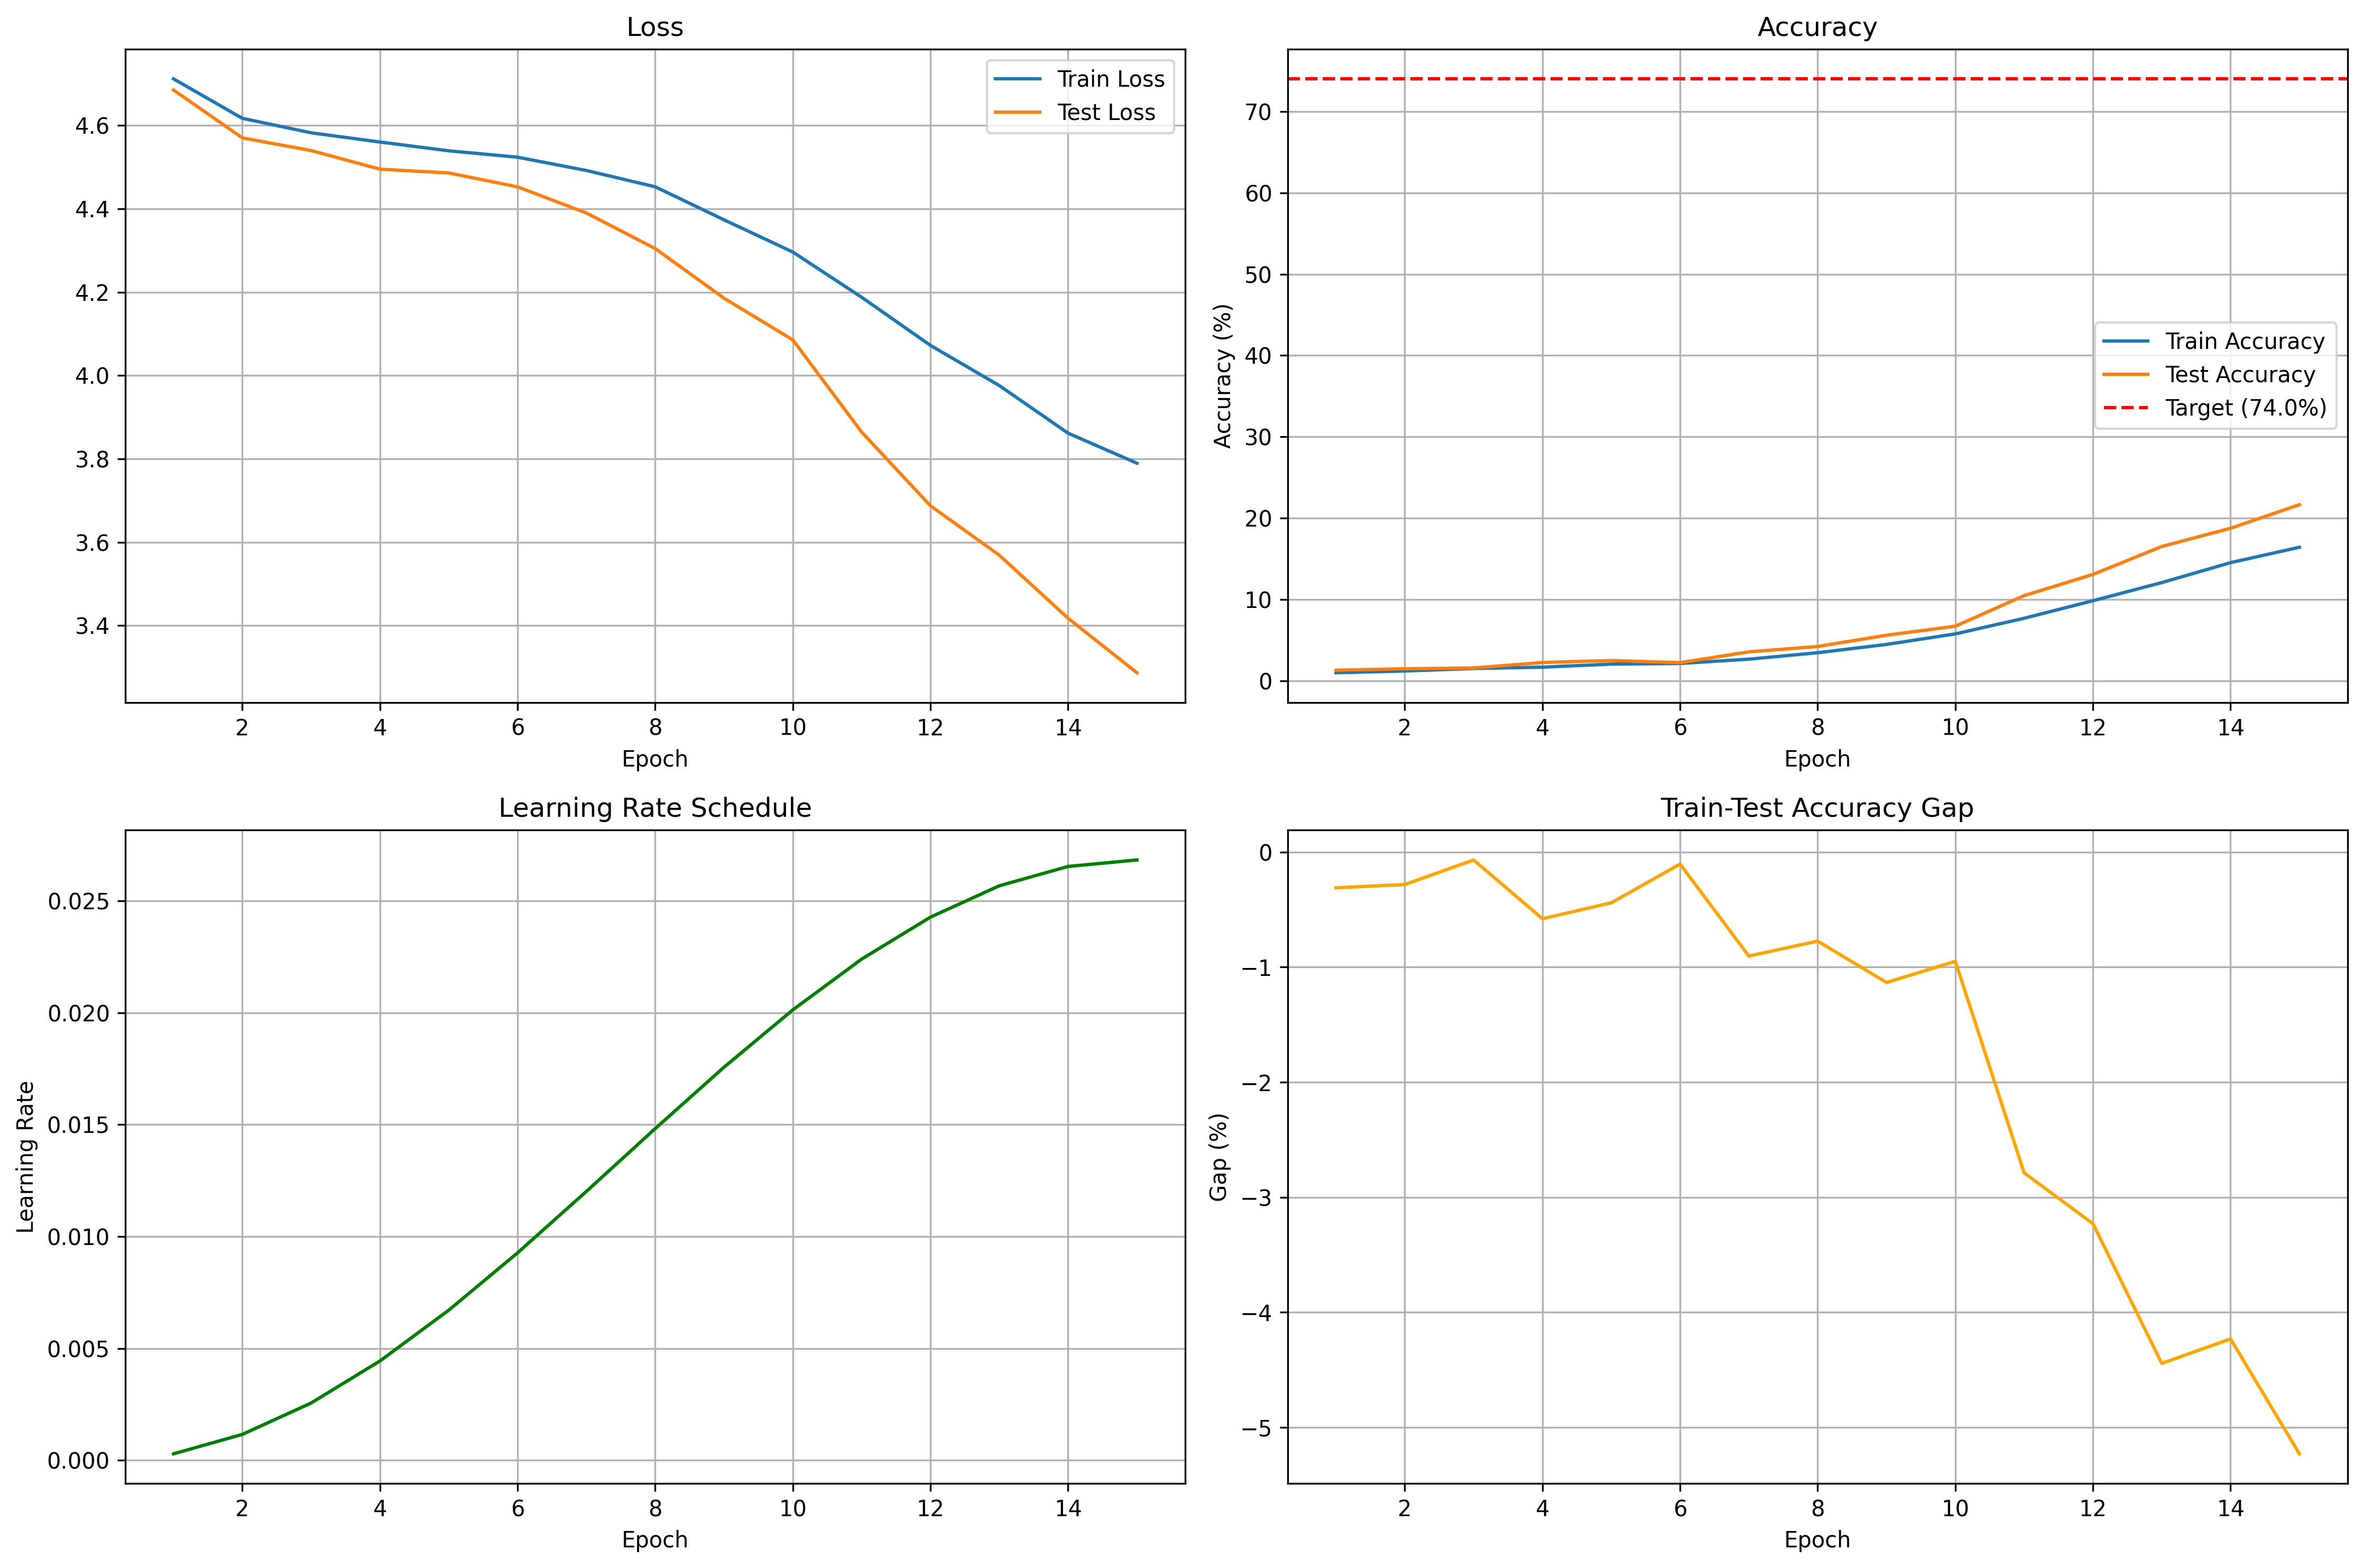


🔍 LR Finder Plot:


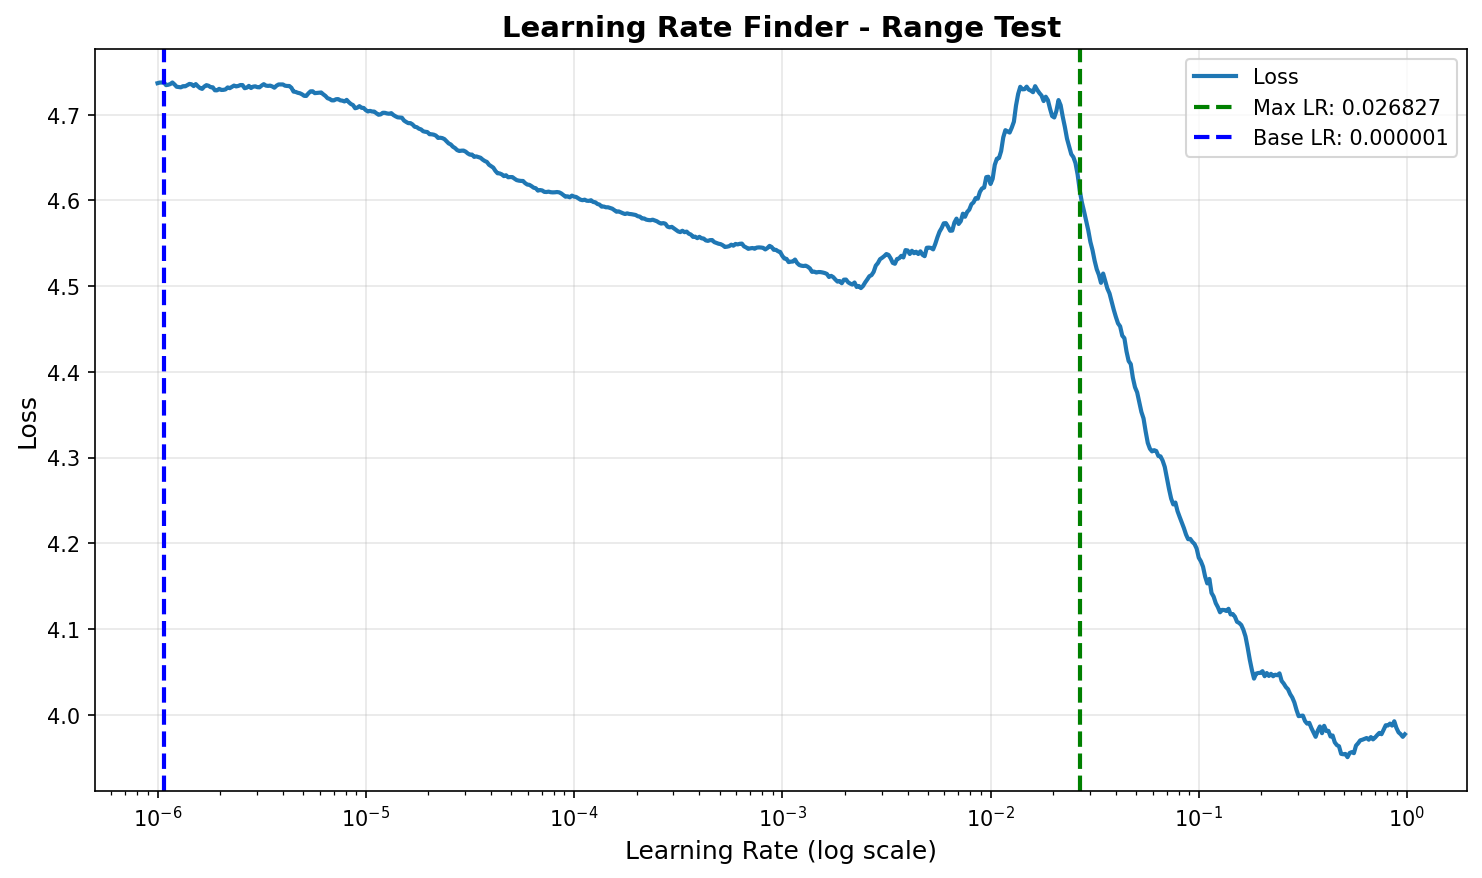

In [13]:
from IPython.display import Image, display

if checkpoint_dirs:
    latest_checkpoint = checkpoint_dirs[0]

    # Display training curves
    curves_path = os.path.join(latest_checkpoint, 'training_curves.png')
    if os.path.exists(curves_path):
        print("📈 Training Curves:")
        print("="*70)
        display(Image(filename=curves_path))
    else:
        print("⚠ Training curves not found.")

    # Display LR Finder plot
    lr_finder_path = os.path.join(latest_checkpoint, 'lr_finder_plot.png')
    if os.path.exists(lr_finder_path):
        print("\n🔍 LR Finder Plot:")
        print("="*70)
        display(Image(filename=lr_finder_path))
    else:
        print("⚠ LR Finder plot not found.")

## Plot Training Metrics (Interactive)

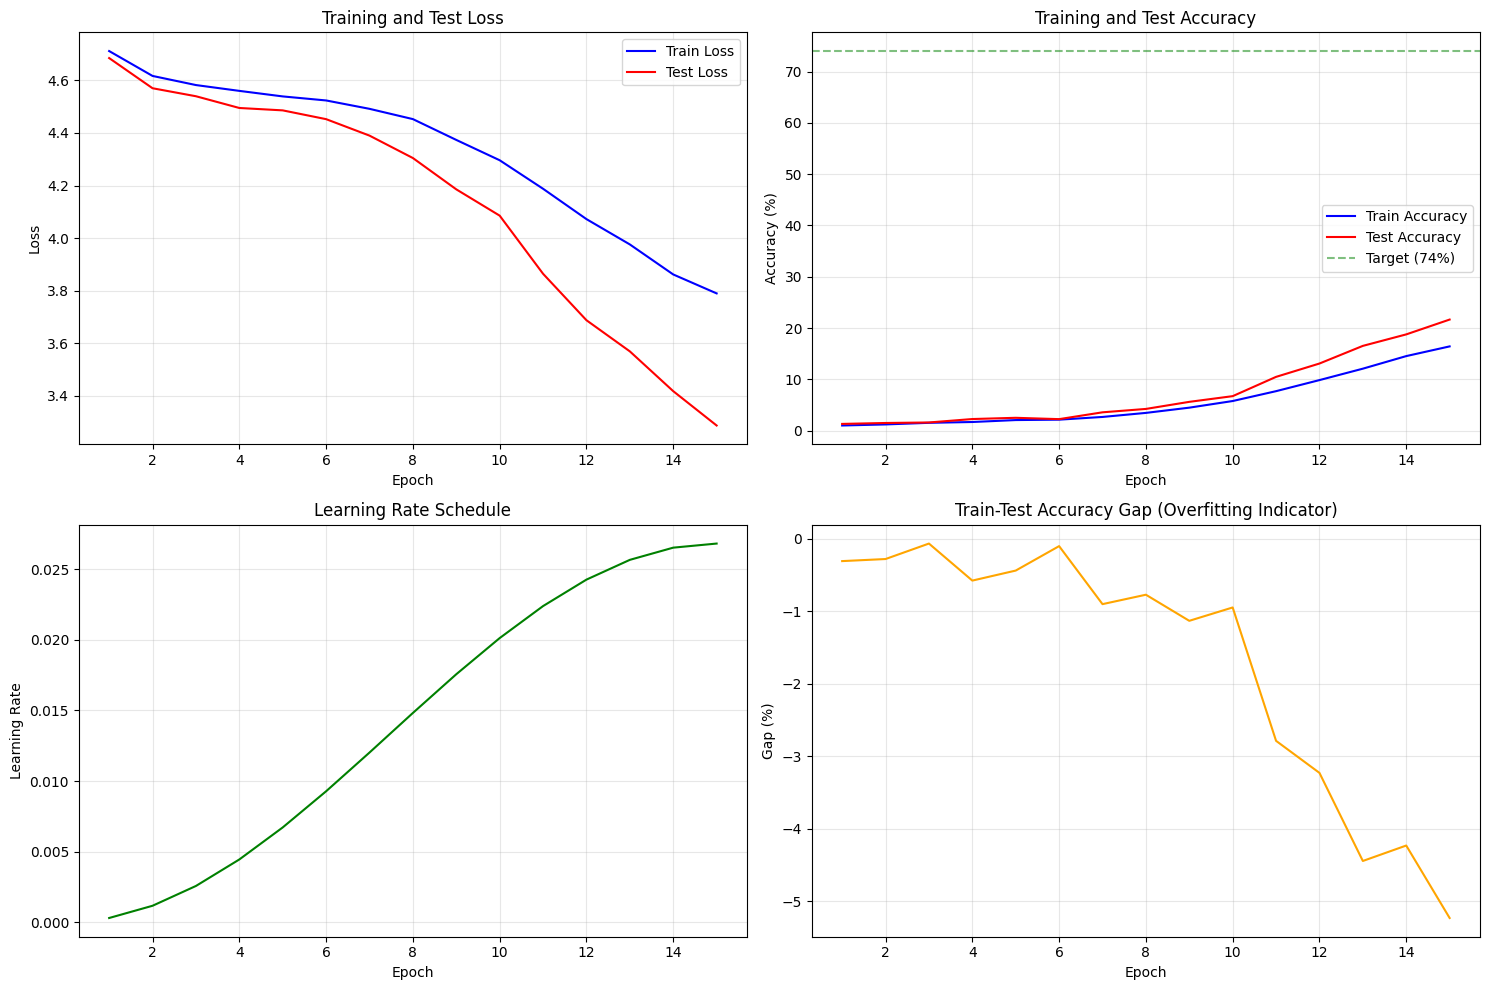


📊 TRAINING SUMMARY
Best Test Accuracy: 21.66% (Epoch 15)
Final Test Accuracy: 21.66%
Final Train-Test Gap: -5.23%
Min Test Loss: 3.2867
Max Learning Rate: 0.026827
Min Learning Rate: 0.000294


In [14]:
import matplotlib.pyplot as plt
import json

if checkpoint_dirs:
    latest_checkpoint = checkpoint_dirs[0]
    metrics_file = os.path.join(latest_checkpoint, 'metrics.json')

    if os.path.exists(metrics_file):
        with open(metrics_file, 'r') as f:
            metrics = json.load(f)

        epochs = metrics['epochs']

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Plot 1: Loss
        axes[0, 0].plot(epochs, metrics['train_losses'], label='Train Loss', color='blue')
        axes[0, 0].plot(epochs, metrics['test_losses'], label='Test Loss', color='red')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Training and Test Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Plot 2: Accuracy
        axes[0, 1].plot(epochs, metrics['train_accuracies'], label='Train Accuracy', color='blue')
        axes[0, 1].plot(epochs, metrics['test_accuracies'], label='Test Accuracy', color='red')
        axes[0, 1].axhline(y=74, color='green', linestyle='--', label='Target (74%)', alpha=0.5)
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy (%)')
        axes[0, 1].set_title('Training and Test Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Plot 3: Learning Rate
        axes[1, 0].plot(epochs, metrics['learning_rates'], color='green')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_title('Learning Rate Schedule')
        axes[1, 0].grid(True, alpha=0.3)

        # Plot 4: Accuracy Gap
        accuracy_gap = [train - test for train, test in zip(metrics['train_accuracies'], metrics['test_accuracies'])]
        axes[1, 1].plot(epochs, accuracy_gap, color='orange')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Gap (%)')
        axes[1, 1].set_title('Train-Test Accuracy Gap (Overfitting Indicator)')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print(f"\n📊 TRAINING SUMMARY")
        print(f"{'='*70}")
        print(f"Best Test Accuracy: {max(metrics['test_accuracies']):.2f}% (Epoch {metrics['test_accuracies'].index(max(metrics['test_accuracies'])) + 1})")
        print(f"Final Test Accuracy: {metrics['test_accuracies'][-1]:.2f}%")
        print(f"Final Train-Test Gap: {accuracy_gap[-1]:.2f}%")
        print(f"Min Test Loss: {min(metrics['test_losses']):.4f}")
        print(f"Max Learning Rate: {max(metrics['learning_rates']):.6f}")
        print(f"Min Learning Rate: {min(metrics['learning_rates']):.6f}")
        print(f"{'='*70}")
    else:
        print("⚠ Metrics file not found.")

## Load Best Model Checkpoint

In [15]:
import torch

if checkpoint_dirs:
    latest_checkpoint = checkpoint_dirs[0]
    best_model_path = os.path.join(latest_checkpoint, 'best_model.pth')

    if os.path.exists(best_model_path):
        # Load the checkpoint with weights_only=False for PyTorch 2.6+
        checkpoint = torch.load(best_model_path, map_location='cpu', weights_only=False)

        print(f"\n{'='*70}")
        print("BEST MODEL CHECKPOINT INFORMATION")
        print(f"{'='*70}")
        print(f"Epoch: {checkpoint['epoch']}")
        print(f"Train Accuracy: {checkpoint['train_accuracy']:.2f}%")
        print(f"Test Accuracy: {checkpoint['test_accuracy']:.2f}%")
        print(f"Train Loss: {checkpoint['train_loss']:.4f}")
        print(f"Test Loss: {checkpoint['test_loss']:.4f}")
        print(f"Timestamp: {checkpoint['timestamp']}")

        print(f"\nModel Configuration:")
        for key, value in checkpoint['config'].items():
            print(f"  - {key}: {value}")

        print(f"{'='*70}\n")

        print("✓ Checkpoint loaded successfully")
        print(f"  Model state dict keys: {len(checkpoint['model_state_dict'])} layers")
        print(f"  Optimizer state dict available: {'optimizer_state_dict' in checkpoint}")

        # Optional: Load model for inference using the new modular structure
        # Uncomment to actually load the model
        # from models import get_model
        # model_name = checkpoint['config'].get('model', 'wideresnet28-10')
        # model = get_model(model_name, num_classes=100)
        # model.load_state_dict(checkpoint['model_state_dict'])
        # model.eval()
        # print("✓ Model loaded and ready for inference")
    else:
        print("⚠ Best model checkpoint not found.")
else:
    print("⚠ No checkpoint directories found.")

⚠ Best model checkpoint not found.


## Download Checkpoint Files (Optional)

Download the trained model and artifacts to your local machine.

In [16]:
from google.colab import files
import shutil

if checkpoint_dirs:
    latest_checkpoint = checkpoint_dirs[0]

    # Create a zip file of the checkpoint directory
    zip_filename = f"{latest_checkpoint}.zip"
    shutil.make_archive(latest_checkpoint, 'zip', latest_checkpoint)

    print(f"✓ Created {zip_filename}")
    print(f"  Size: {os.path.getsize(zip_filename) / (1024*1024):.2f} MB")
    print("\nDownloading...")

    # Download the zip file
    files.download(zip_filename)

    print("✓ Download complete!")
else:
    print("⚠ No checkpoint directories found.")

✓ Created checkpoint_1.zip
  Size: 168.28 MB

Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Download complete!


## Summary

Training is complete using the **new modular codebase**! Here's what was saved:

### 📁 Checkpoint Files:
- `best_model.pth` - The model with the best test accuracy
- `training_curves.png` - Visualization of training progress
- `lr_finder_plot.png` - Learning rate range test results
- `metrics.json` - Complete training history (all epochs)
- `config.json` - Hyperparameter configuration
- `README.md` - Model card with detailed documentation

### 🏗️ Modular Structure Benefits:
- **Datasets** (`datasets/`) - Easy to add CIFAR-10, ImageNet, etc.
- **Models** (`models/`) - Clean separation of architectures
- **Training** (`training/`) - Reusable optimizer, scheduler, LR finder
- **Utils** (`utils/`) - Checkpointing, metrics, HuggingFace upload

### 🔄 Next Steps:
1. Review the training curves to understand model performance
2. Check the LR Finder plot to see the learning rate selection
3. Download the checkpoint files using the cell above
4. (Optional) Upload to HuggingFace Hub if you added credentials

### 🎯 Model Usage (New Modular Way):
To use the trained model with the new modular structure:

```python
import torch
from models import get_model

# Load checkpoint (PyTorch 2.6+ requires weights_only=False)
checkpoint = torch.load('checkpoint_1/best_model.pth',
                       map_location='cpu', weights_only=False)

# Get model using modular factory
model = get_model('wideresnet28-10', num_classes=100)  # or 'resnet50'
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
```

### 🆕 Available Models:
- `wideresnet28-10` - WideResNet-28-10 (36.5M parameters)
- `resnet50` - ResNet50 (23.5M parameters)
- More models can be easily added to `models/` directory!

---

**Thank you for using this training notebook with the new modular structure!**